<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/1_supervised_learning_regression/1-AdvancedLinearRegression_HousePrice.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# House price prediction: Advanced, code your own


In this exercise, we are going to code up our own linear regression model using 1.) least squares and 2.) gradient descent. We will apply to house price prediction using a subset of the [California house price dataset](https://www.kaggle.com/camnugent/california-housing-prices). Our dataset contains 200 observations for housing blocks in California obtained from the 1990 census. The dataset contains columns:

1. `longitude`: A measure of how far west a house is; a higher value is farther west

2. `latitude`: A measure of how far north a house is; a higher value is farther north

3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building

4. `total_rooms`: Total number of rooms within a block

5. `total_bedrooms`: Total number of bedrooms within a block

6. `population`: Total number of people residing within a block

7. `households`: Total number of households, a group of people residing within a home unit, for a block

8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. `median_house_value`: Median house value for households within a block (measured in US Dollars)

10. `ocean_proximity`: Location of the house w.r.t ocean/sea

In this example, we are going to create a regression model to predict `median_house_value` using only `median_income`.

Load the  file `housing_short.csv` in the github repo.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    filepath = "https://raw.githubusercontent.com/lm2612/Tutorials/refs/heads/main/1_supervised_learning_regression/housing_short.csv"
    print(f"Notebook running in google colab. Using raw github filepath = {filepath}")

else:
    filepath = "./housing_short.csv"
    print(f"Notebook running locally. Using local filepath = {filepath}")


Notebook running in google colab. Using raw github filepath = https://raw.githubusercontent.com/lm2612/Tutorials/refs/heads/main/1_supervised_learning_regression/housing_short.csv


In [3]:
df = pd.read_csv(filepath)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


Our goal is to predict `median_house_value`. This will be our independent variable, $y$. Pick another variable that you think will be a useful predictor of house value, that we will use as our dependent variable, $x$. First, we should check if these variables appear correlated by plotting them.

In [67]:
y = df['median_house_value'].values
x = df['median_income'].values

Does your choice of variable seem suitable for linear regression?

## Linear regression
Split the dataset into a suitable training, validation and test set.

In [70]:
val_y = []
val_x = []

test_y = []
test_x = []

train_y = []
train_x = []

for i in range(len(y)):
  if i % 5 == 0:
    val_y.append(y[i])
    val_x.append(x[i])
  elif i % 5 == 1:
    test_y.append(y[i])
    test_x.append(x[i])
  else:
    train_y.append(y[i])
    train_x.append(x[i])

y = [train_y, val_y, test_y]
x = [train_x, val_x, test_x]

Create a linear regression model to predict median house value from median income using the training set. This is the advanced tutorial, so we will be building our linear regression from scratch!

## From scratch
In this notebook, we will code up linear regression using
1. Least squares
2. Gradient descent
3. Stochastic gradient descent.

We will also compare these to the sklearn and pytorch implementations.

### Preprocessing and setup
Get $(X,y)$ arrays and normalise them.

In [72]:
for i in range(3):
    x[i] = np.array(x[i]).reshape(-1, 1)      # This reshapes the array so the inputs are the correct size (N, 1)
    y[i] = np.array(y[i]).reshape(-1, 1)

In [80]:
from sklearn.preprocessing import StandardScaler

# Use StandardScaler to fit and transform your X data so the variables are normalised to zero mean, unit variance
scaler_X = StandardScaler()
scaler_X.fit(x[0])
scaler_y = StandardScaler()
scaler_y.fit(y[0])

X_scaled = []
y_scaled = []

for i in range(3):
    X_scaled.append(scaler_X.transform(x[i]))
    y_scaled.append(scaler_y.transform(y[i]))

X_train = X_scaled[0]
y_train = y_scaled[0]
X_val = X_scaled[1]
y_val = y_scaled[1]

## Least squares

Our linear regression equation is
$$ y = \beta_0 + \beta_1 x_1$$
or in the matrix formulation:
$$\mathbf{y} = \beta \mathbf{X}$$
We have $N$ data pairs of inputs and outputs, which we will index with subscript $i$, i.e., ${\mathbf{X}_i, \mathbf{y}_i}$ where $i=1, \cdots, N$. We use this linear model to make predictions for $\mathbf{y}_i$. The residual error from our linear model is the difference between a prediction and the true data, i.e., $|\mathbf{y}_i - \beta \mathbf{X_i}|$.
We want to find $\beta$ that minimises the residual sum of squares over the dataset, i.e.,
$$\arg \min_\beta \{ \sum_{i=1}^{N} (\mathbf{y}_i - \beta \mathbf{X}_i)^2 \}$$
We will call this term inside the curly brackets our Loss function, $L$.

To minimise this, take the gradient with respect to $\beta$ and set it to zero
$$\frac{dL}{d\beta}= \sum_{i=1}^N (-2 \mathbf{X}_i^T \mathbf{y}_i + 2 \beta \mathbf{X}_i^T \mathbf{X}_i) = 0 $$
$$ \hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \cdot \mathbf{X}^T \mathbf{y} $$
This is the least squares estimate.


Calculate $\beta$

In [77]:
# For the matrix formulation, add a row for the intercept
intercept = np.ones_like(X_train)
X_mat = np.hstack((intercept, X_train))

In [78]:
beta = np.dot(np.linalg.inv(X_mat.T @ X_mat), (X_mat.T @ y_train))
beta

array([[2.23994954e-16],
       [8.49992147e-01]])

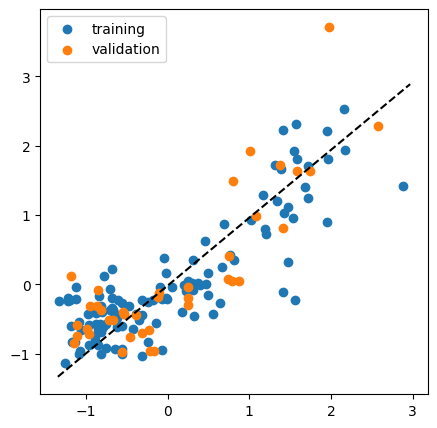

In [83]:
plt.figure(figsize = (5,5))
plt.scatter(y_train, X_mat @ beta, label = 'training')
plt.scatter(y_val, beta[0] + X_val * beta[1], label = 'validation')
plt.plot([min(X_train), max(X_train)], [min(y_train), max(y_train)], color="black", linestyle="dashed")
plt.legend()

## Gradient descent
Instead of analytically computing the gradient, we can also use the gradient descent algorithm to estimate $\hat{\beta}$.

$$ \beta' = \beta - \alpha \nabla L $$
$\alpha$ is called the learning rate and is usually a small number. We can start with 0.01.

1. Start with a guess for $\hat{\beta}$
2. Compute $\hat{\mathbf{y}}=\hat{\beta} \mathbf{X}$.
The mean squared error loss is $L=\frac{1}{N} \sum_{i=1}^{N}{(\hat{\mathbf{y}}_i - \mathbf{y}_i)^2}=\frac{1}{N} \sum_{i=1}^{N}{(\hat{\beta} \mathbf{X}_i - \mathbf{y}_i)^2}$
3. Compute the direction of the gradient of the loss with respect to $\beta$. This is
$$ \nabla L = \frac{1}{N} \sum_{i=1}^{N} 2(\beta \mathbf{X}^T_i \mathbf{X}_i - \mathbf{X}^T_i \mathbf{y}_i) = \frac{1}{N} 2 \mathbf{X}^T \cdot (\hat{\mathbf{y}} - \mathbf{y})$$
4. Update our estimate of $\beta$ by taking the step in the direction of reducing the gradient.
5. Repeat steps 2-4. until our estimate of $\beta$ converges.

Code up gradient descent and carry out 100 iterations. Then plot the coefficient, intercept and the loss for these iterations.

In [48]:
# Choose your learning rate
alpha = 0.05

# store intercept and coefficients for plotting
intercepts = []
coefficients = []
losses = []


# initialise beta_hat randomly
beta_hat = np.random.rand(2, 1)

for t in range(100):
    y_hat = X_mat @ beta_hat
    N = len(y_scaled)
    # loss
    L = 1 / N * np.sum((y_hat - y_scaled)**2)

    # compute direction of gradient
    d_L =  2 / N * np.dot(X_mat.T, (y_hat - y_scaled))

    # update
    beta_hat = beta_hat - alpha * d_L

    # store
    intercepts.append(beta_hat[0,0])
    coefficients.append(beta_hat[1,0])
    losses.append(L)


Text(0.5, 1.0, 'MSE')

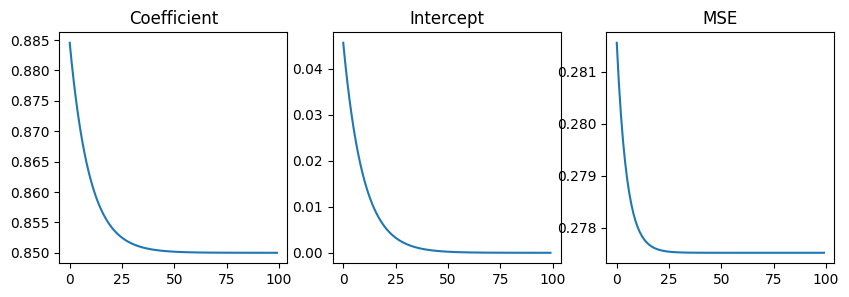

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(coefficients)
axs[0].set_title("Coefficient")

axs[1].plot(intercepts)
axs[1].set_title("Intercept")

axs[2].plot(losses)
axs[2].set_title("MSE")

Try different values for $\alpha$. What happens?

## Stochastic gradient descent

With a relatively small dataset, we can estimate the gradient over the entire dataset. But when we have larger datasets, this becomes computationally expensive. Stochatic gradient descent is a stochastic approximation of gradient descent optimization. It replaces the true gradient calculated from the entire data set with an estimate of it, calculated from a randomly selected subset of the data.

Use a batch size of 32 and carry out gradient descent on one batch at a time. Iterate through the data 100 times (epochs).

In [50]:
batch_size = 32
N = X_mat.shape[0]
data_inds = np.arange(N)
np.random.shuffle(data_inds)
# Check the data are shuffled
data_inds

array([ 75,  83, 109,  65,  52,  11,  30,  45,  13,  53, 117,  96, 115,
        99,   6,  14,  85,  68, 113,  22,   4, 119,  80,  86,  72,  48,
        40,  51,  66,  47,  92,  82,  55,  77,  27,   2,   0,  16,  62,
        37,  54,  12,  34,  43,  89,  32,  84,  38,  79,   9,  61,  93,
       107,  58,  25,  87,  69,  26,  59,  81, 100,  95, 106,  64,  76,
        57, 118,  10,  15,  50,  94,  71,  49,  23, 110,  44,  78, 114,
        88,  60,  18, 108,  24,  98,   5,  36,   7, 102,  31,  46,  56,
        67,  70, 105,  63,  90, 111, 116, 103, 104,  35,   1,  74,  28,
        97,  39, 112, 101,  19,  21,   3,  91,  41,  42,  29,  17,  20,
        33,  73,   8])

In [54]:
# Now build your loop over 100 epochs and an inner over the batches

# Choose your learning rate
alpha = 0.05

# store intercept and coefficients for plotting
intercepts = []
coefficients = []
losses = []


# initialise beta_hat randomly
beta_hat = np.random.rand(2, 1)

for i in range(100):
    np.random.shuffle(data_inds)
    X_shuffled = X_mat[data_inds]
    y_shuffled = y_scaled[data_inds]

    for b in range(N//batch_size):
        X_batch = X_shuffled[b*batch_size:(b+1)*batch_size]
        y_batch = y_shuffled[b*batch_size:(b+1)*batch_size]

        y_hat = X_batch @ beta_hat

        # compute direction of gradient
        d_L =  2*np.dot(X_batch.T, y_hat - y_batch)/N

        # update
        beta_hat = beta_hat - alpha * d_L

        # store
        intercepts.append(beta_hat[0,0])
        coefficients.append(beta_hat[1,0])
        losses.append(np.sum((y_hat - y_batch)**2))


Text(0.5, 1.0, 'MSE')

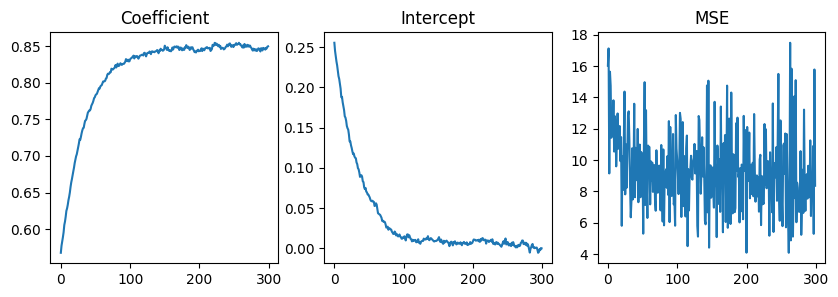

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(coefficients)
axs[0].set_title("Coefficient")

axs[1].plot(intercepts)
axs[1].set_title("Intercept")

axs[2].plot(losses)
axs[2].set_title("MSE")

## Scikit-learn solution
Compare your results to the sklearn solution `sklearn.linear_model.LinearRegression()`. See https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html.

In [56]:
from sklearn import linear_model

# Create your linear regression model and print the coefficients and intercept.
reg = linear_model.LinearRegression()
reg.fit(X_scaled, y_scaled)

# print coefficients of model
coefficient_SK = reg.coef_[0,0]
intercept_SK = reg.intercept_[0]
print(f"sklearn estimate: intercept {intercept_SK:.4e}, coefficient {coefficient_SK:.4e}")

sklearn estimate: intercept 2.1594e-16, coefficient 8.4999e-01


Do you get the same results?

## Pytorch solution
Can you also use a pytorch implementation of linear regression? Explore different learning rates and see how quickly your parameters converge
          


In [57]:
import torch

# Create a linear layer (1D-> 1D) using torch.nn.Linear(...)
linear_layer = torch.nn.Linear(in_features=1, out_features=1)
# For optimiser, look at the docs for torch.optim.SGD()
optimiser = torch.optim.SGD(params = linear_layer.parameters(), lr=0.1)
# For the loss function, look at the docs for torch.nn.MSE()
loss_function = torch.nn.MSELoss()

Check the parameters of your neural network. There should be two: one for the coefficient/weight and one for the intercept/bias.

In [59]:
for p in linear_layer.parameters():
    print(p)

Parameter containing:
tensor([[-0.5151]], requires_grad=True)
Parameter containing:
tensor([0.6281], requires_grad=True)


In [58]:
# Convert your np arrays into torch tensors using torch.tensor(...)
X_torch = torch.tensor(X_scaled, dtype=torch.float32)
y_torch = torch.tensor(y_scaled, dtype=torch.float32)

In [60]:
# Store parameters for plotting
coefficients = []
intercepts = []
losses = []

for iteration in range(100):
    optimiser.zero_grad()
    pred = linear_layer(X_torch)
    loss = loss_function(pred, y_torch)
    loss.backward()

    for p, param in enumerate(linear_layer.parameters()):
        if p==0:
            coefficients.append(param.item())
        elif p==1:
            intercepts.append(param.item())
    losses.append(loss.item())

    # Update optimiser
    optimiser.step()


Check your parameters after training - they should have converged to the same values as the least squares estimates.

In [61]:
for p in linear_layer.parameters():
    print(p)

Parameter containing:
tensor([[0.8500]], requires_grad=True)
Parameter containing:
tensor([1.0660e-08], requires_grad=True)


Text(0.5, 1.0, 'MSE')

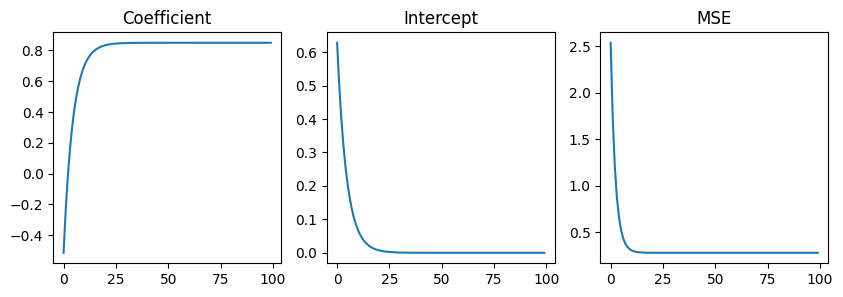

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(coefficients)
axs[0].set_title("Coefficient")

axs[1].plot(intercepts)
axs[1].set_title("Intercept")

axs[2].plot(losses)
axs[2].set_title("MSE")